In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Data preparation

In [4]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv'

In [5]:
#!wget $data

In [6]:
df = pd.read_csv('course_lead_scoring.csv')
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [7]:
df.isna().sum()

lead_source                 128
industry                    134
number_of_courses_viewed      0
annual_income               181
employment_status           100
location                     63
interaction_count             0
lead_score                    0
converted                     0
dtype: int64

In [8]:
categorical = ['lead_source','industry','employment_status','location']
numerical = ['number_of_courses_viewed','annual_income','interaction_count','lead_score']

In [9]:
df[categorical] = df[categorical].fillna('NA')
df[numerical] = df[numerical].fillna(0.0)

In [10]:
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

del df_train['converted']
del df_val['converted']
del df_test['converted']

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Question 1: ROC AUC feature importance

In [13]:
from sklearn.metrics import roc_auc_score

In [14]:
for n in numerical:
    n_pred = np.array(df_train[n])
    score = roc_auc_score(y_train, n_pred)
    print(n, round(score,3))

number_of_courses_viewed 0.764
annual_income 0.552
interaction_count 0.738
lead_score 0.614


### Which numerical variable (among the following 4) has the highest AUC? — number_of_courses_viewed

# Question 2: Training the model

In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [16]:
# LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

dv = DictVectorizer(sparse=False)

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000).fit(X_train, y_train)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_pred = model.predict_proba(X_val)[:,1]

In [17]:
score = roc_auc_score(y_val, y_pred)
round(score,3)

0.817

### What's the AUC of this model on the validation dataset? (round to 3 digits) — 0.92

# Question 3: Precision and Recall

Now let's compute precision and recall for our model.

Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
For each threshold, compute precision and recall
Plot them
At which threshold precision and recall curves intersect?

In [18]:
actual_positiv = (y_val == 1)
actual_negative = (y_val == 0)

thresholds = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    # true positive
    tp = (predict_positive & actual_positiv).sum()
    # true negative
    tn = (predict_negative & actual_negative).sum()
    # false positive 
    fp = (predict_positive & actual_negative).sum()
    # false negative
    fn = (predict_negative & actual_positiv).sum()

    # p - precision
    p = tp / (tp + fp)

    # r - recall
    r = tp / (tp + fn)

    scores.append([t, p, r])

columns = ['threshold', 'p','r']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores
    

/var/folders/fy/xyh07_qn3vd2x6f9bgwmgxsm0000gn/T/ipykernel_67918/1778061235.py:22: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


,threshold,p,r
0,0.00,0.583618,1.000000
1,0.01,0.583618,1.000000
2,0.02,0.583618,1.000000
3,0.03,0.583618,1.000000
4,0.04,0.583618,1.000000
...,...,...,...
96,0.96,1.000000,0.017544
97,0.97,1.000000,0.005848
98,0.98,NaN,0.000000
99,0.99,NaN,0.000000


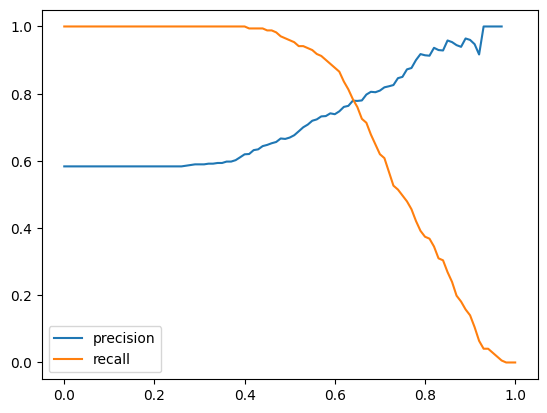

In [19]:
plt.plot(df_scores['threshold'], df_scores['p'], label='precision')
plt.plot(df_scores['threshold'], df_scores['r'],label='recall')
plt.legend()

### At which threshold precision and recall curves intersect? — 0.65 (closest 0.745)

# Question 4: F1 score

In [20]:
for t in thresholds:
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    # true positive
    tp = (predict_positive & actual_positiv).sum()
    # true negative
    tn = (predict_negative & actual_negative).sum()
    # false positive 
    fp = (predict_positive & actual_negative).sum()
    # false negative
    fn = (predict_negative & actual_positiv).sum()

    # p - precision
    p = tp / (tp + fp)

    # r - recall
    r = tp / (tp + fn)

    f1 = round( (2 * (p*r) /(p+r) ) ,3 )

    print(f'threshold {round(t,2)} —', f1)

threshold 0.0 — 0.737
threshold 0.01 — 0.737
threshold 0.02 — 0.737
threshold 0.03 — 0.737
threshold 0.04 — 0.737
threshold 0.05 — 0.737
threshold 0.06 — 0.737
threshold 0.07 — 0.737
threshold 0.08 — 0.737
threshold 0.09 — 0.737
threshold 0.1 — 0.737
threshold 0.11 — 0.737
threshold 0.12 — 0.737
threshold 0.13 — 0.737
threshold 0.14 — 0.737
threshold 0.15 — 0.737
threshold 0.16 — 0.737
threshold 0.17 — 0.737
threshold 0.18 — 0.737
threshold 0.19 — 0.737
threshold 0.2 — 0.737
threshold 0.21 — 0.737
threshold 0.22 — 0.737
threshold 0.23 — 0.737
threshold 0.24 — 0.737
threshold 0.25 — 0.737
threshold 0.26 — 0.737
threshold 0.27 — 0.739
threshold 0.28 — 0.74
threshold 0.29 — 0.742
threshold 0.3 — 0.742
threshold 0.31 — 0.742
threshold 0.32 — 0.743
threshold 0.33 — 0.743
threshold 0.34 — 0.745
threshold 0.35 — 0.745
threshold 0.36 — 0.748
threshold 0.37 — 0.748
threshold 0.38 — 0.752
threshold 0.39 — 0.758
threshold 0.4 — 0.765
threshold 0.41 — 0.764
threshold 0.42 — 0.773
threshold 0.43 — 

/var/folders/fy/xyh07_qn3vd2x6f9bgwmgxsm0000gn/T/ipykernel_67918/288592807.py:15: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


### At which threshold F1 is maximal? — threshold 0.57 — 0.812 (closest 0.54)

# Question 5: 5-Fold CV

In [26]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [27]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [29]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [30]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [35]:
scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):

    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train['converted']
    del df_val['converted']

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print(round(np.std(scores),3))

0it [00:00, ?it/s]

0.036


### How large is standard deviation of the scores across different folds? — 0.036

# Question 6: Hyperparameter Tuning

In [37]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [38]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    scores = []

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train), total=n_splits):
    
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.converted.values
        y_val = df_val.converted.values

        del df_train['converted']
        del df_val['converted']
    
        dv, model = train(df_train, y_train, C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

C=1e-06 0.560 +- 0.024


  0%|          | 0/5 [00:00<?, ?it/s]

C=0.001 0.867 +- 0.029


  0%|          | 0/5 [00:00<?, ?it/s]

C=1 0.822 +- 0.036


### Which C leads to the best mean score? — C=0.001 0.867 +- 0.029